# Mobile tariff recommendations

You need to build a model for the classification problem that will choose the appropriate tariff.

## Import libraries

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 

plt.style.use('dark_background')
RANDOM_STATE = 42

## Preprocessing data

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
df.duplicated().sum()

0

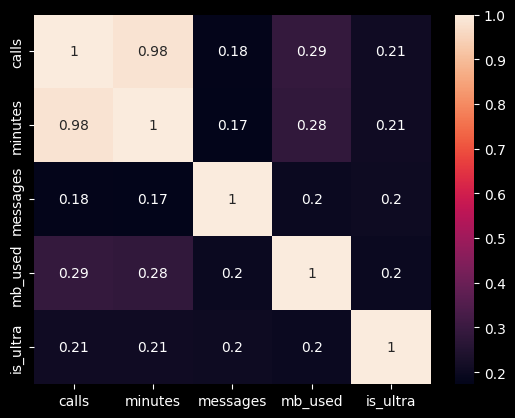

In [8]:
sns.heatmap(df.corr(), annot=True);

We see a strong correlation between "calls" and "minutes". This negatively affects the fit. Let's remove the "minutes" from the features.

In [9]:
df.is_ultra.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [10]:
X = df.drop(['is_ultra', 'minutes'], axis=1)
y = df['is_ultra']

In [11]:
def scatter_plot(X, y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    ax1.scatter(X['messages'], X['calls'], c=y, edgecolors='b')
    ax1.set_xlabel('calls')
    ax1.set_ylabel('messages')
    ax1.set_title('Tariffs')
    plt.grid()
    
    sns.histplot(y, ax=ax2)
    ax2.set_title('Target')
    ax2.set_ylim(0, 2500);

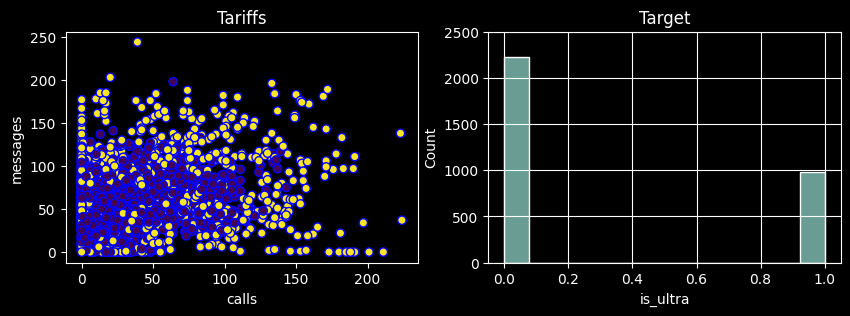

In [12]:
scatter_plot(X, y)

We don't have duplicates and missing values, but we have imbalanced classes. Let's split dataset into train and test samples.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2571, 3), (2571,), (643, 3), (643,))

## Building models

In [15]:
def clf_models(X_train, y_train, resampling=None, 
               class_weight: str = None, class_weight_catboost: str = None):
    models = []
    results = pd.DataFrame(columns=['mean_fit_time', 'params', 'mean_test_score'])

    # LogisticRegression
    X_train_lr = X_train.copy()
    y_train_lr = y_train.copy()

    lr = Pipeline(
        [('resamling', resampling),
         ('scaler', StandardScaler()),
         ('lr', LogisticRegression(class_weight = class_weight, random_state=RANDOM_STATE))
             ]
             )
    params_lr = {'lr__C': np.logspace(-5, 5, 11)}
    grid_lr = GridSearchCV(lr, param_grid=params_lr, cv=5, scoring='f1', n_jobs=-1)
    grid_lr.fit(X_train_lr, y_train_lr)
    best_result_lr = pd.DataFrame(
        grid_lr.cv_results_).sort_values('rank_test_score').head(1)
    best_result_lr = best_result_lr[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_lr.best_estimator_)

    # SGDClassifier
    X_train_sgd = X_train.copy()
    y_train_sgd = y_train.copy()

    sgd = Pipeline(
        [('resamling', resampling),
            ('scaler', StandardScaler()),
          ('sgd', SGDClassifier(class_weight = class_weight, random_state=RANDOM_STATE))
             ]
             )
    params_sgd = {'sgd__alpha': range(1, 10),
                  'sgd__penalty': ['l2', 'l1', 'elasticnet', None]}
    grid_sgd = GridSearchCV(sgd, param_grid=params_sgd, cv=5, scoring='f1', n_jobs=-1)
    grid_sgd.fit(X_train_sgd, y_train_sgd)
    best_result_sgd = pd.DataFrame(
        grid_sgd.cv_results_).sort_values('rank_test_score').head(1)
    best_result_sgd = best_result_sgd[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_sgd.best_estimator_)

    # RidgeClassifier
    X_train_rd = X_train.copy()
    y_train_rd = y_train.copy()

    rd = Pipeline(
        [('resamling', resampling),
            ('scaler', StandardScaler()),
          ('rd', RidgeClassifier(class_weight = class_weight, random_state=RANDOM_STATE))
             ]
             )
    params_rd = {'rd__alpha': range(1, 10)}
    grid_rd = GridSearchCV(rd, param_grid=params_rd, cv=5, scoring='f1', n_jobs=-1)
    grid_rd.fit(X_train_rd, y_train_rd)
    best_result_rd = pd.DataFrame(
        grid_rd.cv_results_).sort_values('rank_test_score').head(1)
    best_result_rd = best_result_rd[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_rd.best_estimator_)

    # GaussianNB
    X_train_nb = X_train.copy()
    y_train_nb = y_train.copy()

    nb = Pipeline(
        [('resamling', resampling),
            ('scaler', StandardScaler()),
          ('nb', GaussianNB())
             ]
             )
    params_nb = {'nb__var_smoothing': np.logspace(0,-9, num=100)}
    grid_nb = GridSearchCV(nb, param_grid=params_nb, cv=5, scoring='f1', n_jobs=-1)
    grid_nb.fit(X_train_nb, y_train_nb)
    best_result_nb = pd.DataFrame(
        grid_rd.cv_results_).sort_values('rank_test_score').head(1)
    best_result_nb = best_result_nb[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_rd.best_estimator_)

    # SVC
    X_train_svc = X_train.copy()
    y_train_svc = y_train.copy()

    svc = Pipeline(
        [('resamling', resampling),
            ('scaler', StandardScaler()),
          ('svc', SVC(class_weight = class_weight, random_state=RANDOM_STATE))
             ]
             )
    params_svc = {'svc__C': [0.1, 1, 10, 100], 
                  'svc__gamma': [ 1, 0.1, 0.01, 0.001],
                  'svc__kernel': ['rbf', 'poly', 'sigmoid']}
    grid_svc = GridSearchCV(svc, param_grid=params_svc, cv=5, scoring='f1', n_jobs=-1)
    grid_svc.fit(X_train_svc, y_train_svc)
    best_result_svc = pd.DataFrame(
        grid_svc.cv_results_).sort_values('rank_test_score').head(1)
    best_result_svc = best_result_svc[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_svc.best_estimator_)

    # KNeighborsClassifier
    X_train_knn = X_train.copy()
    y_train_knn = y_train.copy()

    knn = Pipeline(
        [('resamling', resampling),
            ('scaler', StandardScaler()),
          ('knn', KNeighborsClassifier())
             ]
             )
    params_knn = {'knn__n_neighbors': [100, 200, 300], 
                  'knn__weights': ['uniform', 'distance'],
                  'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    grid_knn = GridSearchCV(knn, param_grid=params_knn, cv=5, scoring='f1', n_jobs=-1)
    grid_knn.fit(X_train_knn, y_train_knn)
    best_result_knn = pd.DataFrame(
        grid_knn.cv_results_).sort_values('rank_test_score').head(1)
    best_result_knn = best_result_knn[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_knn.best_estimator_)

    # CatBoostClassifier
    X_train_cb = X_train.copy()
    y_train_cb = y_train.copy()

    pipline_cb = Pipeline(
        [('resamling', resampling),
         ('scaler', StandardScaler()),
         ('cb', CatBoostClassifier(auto_class_weights=class_weight_catboost, random_state=RANDOM_STATE, verbose=False))])

    param_cb = {'cb__max_depth': [3, 5, 7],
                'cb__n_estimators': [1000, 2000, 3000, 4000, 5000]}
    grid_cb = GridSearchCV(pipline_cb, param_grid=param_cb,
                           scoring='f1', cv=5, n_jobs=-1)
    grid_cb.fit(X_train_cb, y_train_cb)
    best_result_cb = pd.DataFrame(
        grid_cb.cv_results_).sort_values('rank_test_score').head(1)
    best_result_cb = best_result_cb[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_cb.best_estimator_)

    #result
    result = pd.concat([best_result_lr, best_result_sgd, 
                        best_result_rd, best_result_nb, 
                        best_result_svc, best_result_knn, 
                        best_result_cb])
    result.index = ['LogisticRegression', 'SGDClassifier', 
                    'RidgeClassifier', 'GaussianNB',
                    'SVC', 'KNeighborsClassifier', 
                    'CatBoostClassifier']
    display(result)
    return models

## Training models

Let's train models with different methods of dealing imbalance.

### Default sample

In [16]:
general_models = clf_models(X_train, y_train)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.013989,{'lr__C': 1.0},0.342353
SGDClassifier,0.006258,"{'sgd__alpha': 1, 'sgd__penalty': None}",0.187188
RidgeClassifier,0.007725,{'rd__alpha': 1},0.307925
GaussianNB,0.007725,{'rd__alpha': 1},0.307925
SVC,0.219611,"{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': ...",0.608660
KNeighborsClassifier,0.004738,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.470288
CatBoostClassifier,3.906037,"{'cb__max_depth': 5, 'cb__n_estimators': 2000}",0.639782


### Class weight

In [17]:
models_class_weight = clf_models(X_train, y_train, class_weight='balanced', class_weight_catboost='Balanced')

,mean_fit_time,params,mean_test_score
LogisticRegression,0.008883,{'lr__C': 1e-05},0.499056
SGDClassifier,0.006176,"{'sgd__alpha': 1, 'sgd__penalty': None}",0.482053
RidgeClassifier,0.007461,{'rd__alpha': 1},0.493902
GaussianNB,0.007461,{'rd__alpha': 1},0.493902
SVC,0.154831,"{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': ...",0.658899
KNeighborsClassifier,0.004995,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.470288
CatBoostClassifier,4.083343,"{'cb__max_depth': 5, 'cb__n_estimators': 2000}",0.653734


### Undersampling

In [18]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

In [19]:
models_rus = clf_models(X_train, y_train, rus)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.011590,{'lr__C': 1e-05},0.504196
SGDClassifier,0.010487,"{'sgd__alpha': 1, 'sgd__penalty': None}",0.485234
RidgeClassifier,0.010907,{'rd__alpha': 1},0.493444
GaussianNB,0.010907,{'rd__alpha': 1},0.493444
SVC,0.060044,"{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': ...",0.657145
KNeighborsClassifier,0.008078,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.618948
CatBoostClassifier,1.577846,"{'cb__max_depth': 5, 'cb__n_estimators': 1000}",0.642863


### Oversampling

In [20]:
ros = RandomOverSampler(random_state=RANDOM_STATE)

In [21]:
models_ros = clf_models(X_train, y_train, ros)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.012271,{'lr__C': 1e-05},0.499681
SGDClassifier,0.011354,"{'sgd__alpha': 1, 'sgd__penalty': None}",0.492249
RidgeClassifier,0.011315,{'rd__alpha': 1},0.496851
GaussianNB,0.011315,{'rd__alpha': 1},0.496851
SVC,0.290641,"{'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel'...",0.656173
KNeighborsClassifier,0.009649,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.645470
CatBoostClassifier,6.859024,"{'cb__max_depth': 5, 'cb__n_estimators': 3000}",0.650217


### SMOTE

In [22]:
sm = SMOTE(random_state=RANDOM_STATE)

In [23]:
models_res = clf_models(X_train, y_train, sm)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.014213,{'lr__C': 1e-05},0.497795
SGDClassifier,0.012867,"{'sgd__alpha': 2, 'sgd__penalty': None}",0.493107
RidgeClassifier,0.012954,{'rd__alpha': 1},0.488353
GaussianNB,0.012954,{'rd__alpha': 1},0.488353
SVC,0.295045,"{'svc__C': 100, 'svc__gamma': 0.01, 'svc__kern...",0.644558
KNeighborsClassifier,0.012140,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.628311
CatBoostClassifier,9.984256,"{'cb__max_depth': 5, 'cb__n_estimators': 4000}",0.650560


## Testing models

We determined three models, which had shown us the best results. Check them on test sample.

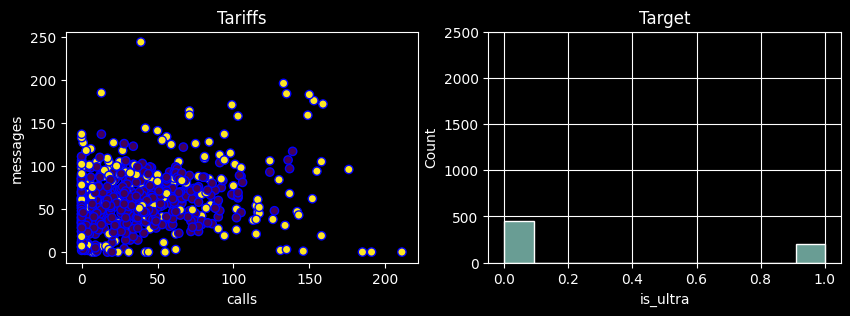

In [24]:
scatter_plot(X_test, y_test)

In [25]:
df_test = pd.DataFrame(index=['SVC', 'KNeighborsClassifier', 'CatBoostClassifier'])
for name, models in ({'Default': general_models,
                'Class_weight': models_class_weight, 
                'Undersampling': models_rus, 
                'Oversampling': models_ros, 
                'SMOTE': models_res}).items():
    results = []
    for i in [4, 5, 6]:
          results.append(f1_score(y_test, models[i].predict(X_test)))
    df_test[name] = results

df_test

,Default,Class_weight,Undersampling,Oversampling,SMOTE
SVC,0.619355,0.678663,0.676768,0.677165,0.686327
KNeighborsClassifier,0.521429,0.521429,0.692737,0.693122,0.675532
CatBoostClassifier,0.634146,0.682415,0.698020,0.672000,0.685864


We got the best result for the test sample using the CatBoostClassifier. Let's build a confusion matrix and look at each parameter separately.

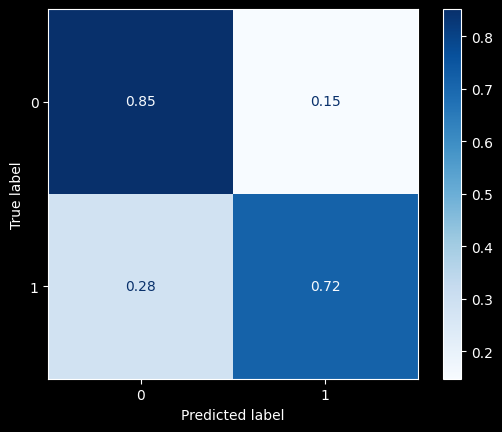

In [26]:
ConfusionMatrixDisplay.from_estimator(models_rus[6], X_test, y_test, normalize='true', cmap='Blues', colorbar=True);

We see that only 72% of the minority class is defined correctly. Let's check through the ROC-AUC the possibility to increase this indicator by changing the threshold.

In [27]:
probabilities = models_rus[6].predict_proba(X_test)
y_score = probabilities[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': threshold})
roc_auc['tpr-fpr'] = roc_auc['tpr'] - roc_auc['fpr']
roc_auc.sort_values('tpr-fpr', ascending=False)

,tpr,fpr,threshold,tpr-fpr
94,0.756345,0.172646,0.472169,0.583699
88,0.730964,0.154709,0.490236,0.576256
92,0.746193,0.170404,0.477628,0.575789
86,0.725888,0.150224,0.494098,0.575664
93,0.746193,0.172646,0.476640,0.573547
...,...,...,...,...
2,0.081218,0.000000,0.993580,0.081218
3,0.081218,0.002242,0.991685,0.078976
1,0.005076,0.000000,0.998376,0.005076
0,0.000000,0.000000,1.998376,0.000000


The best threshold at which the difference between tpr and fpr is maximum is 0.5

'ROC-AUC score:'

0.783876988914434

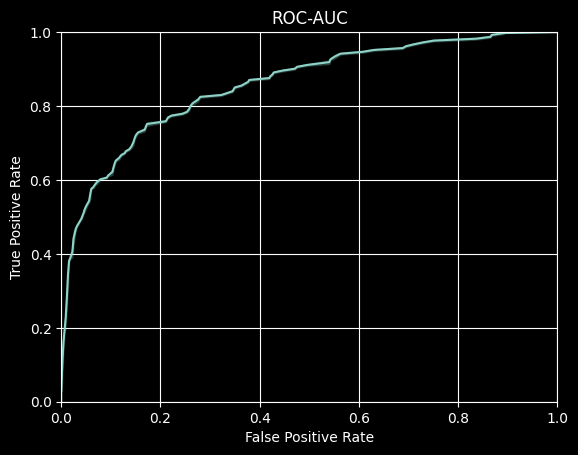

In [28]:
sns.lineplot(x=fpr, y=tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("ROC-AUC");
display('ROC-AUC score:', roc_auc_score(y_test, models_rus[6].predict(X_test)))

In [29]:
optimal_threshold = roc_auc.sort_values('tpr-fpr', ascending=False)['threshold'].head(1).values[0]
optimal_threshold

0.47216940259690343

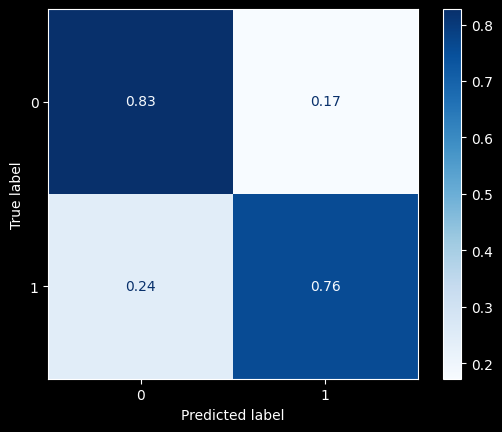

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_score >= optimal_threshold, normalize='true', colorbar=True, cmap='Blues');

## Conclusion

We received a data set that did not require pre-processing of the data. During the analysis, an imbalance of classes was revealed, which we took into account in the process of teaching seven different models. Based on the results of the training, 3 models with a higher f1 score were identified. After testing models with various methods to eliminate the imbalance, a Cat Boost classifier model was selected, trained using the insufficient sampling method.
Using ROC-AUC, we can determine the best threshold at which the difference between tpr and fpr will be maximal. In our case, it turned out to be 0.47. Thus, by changing the threshold to optimal, we improved the definition of the minority class by 4%.